# Convolutional Neural Network for Sentiment Classification

This notebook comprises the network architecture used for senciment classification using as input human faces.

#### Import Dependencies

In [1]:
import numpy as np
np.random.seed(42)

In [2]:
import os
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Flatten, BatchNormalization
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

from keras.preprocessing.image import ImageDataGenerator

from keras_contrib.layers.advanced_activations import SineReLU

from sklearn.model_selection import train_test_split

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Hyper-Parameters

In [3]:
num_classes = 7

image_size=(48, 48)
input_shape = (48, 48, 1)

labels = {0:'angry',1:'disgust',2:'fear',3:'happy', 4:'sad',5:'surprise',6:'neutral'}

batch_size = 128
num_epochs = 5
validation_split = .1
test_split = .1
patience = 10
dropout = .2

e_param_cnn = 0.0025
e_param_dense = 0.0083

dataset_path = '../../dataset/fer2013.csv'
model_output = '../models/best_model_weights_BETA.hdf5'

#### Load Dataset

In [4]:
data = pd.read_csv(dataset_path)

In [5]:
def load_dataset():
    pixels = data['pixels']
    
    faces = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(48, 48)
        faces.append(face.astype('float32'))

    faces = np.asarray(faces)
    emotions = keras.utils.to_categorical(data['emotion'], num_classes)
    
    return faces, emotions

#### Pre-Process Dataset

In [6]:
faces, emotions = load_dataset()

train_faces, val_faces, train_emotions, val_emotions = train_test_split(faces, emotions, test_size=validation_split)
train_faces, test_faces, train_emotions, test_emotions = train_test_split(train_faces, train_emotions, test_size=test_split)

train_faces = train_faces.reshape(-1, 48, 48, 1)
val_faces = val_faces.reshape(-1, 48, 48, 1)
test_faces = test_faces.reshape(-1, 48, 48, 1)

train_faces = train_faces.astype("float32")/255.
val_faces = val_faces.astype("float32")/255.
test_faces = test_faces.astype("float32")/255.

#### Network Architecture

In [7]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(7, 7), padding='same', input_shape=input_shape))
# model.add(BatchNormalization())
model.add(Conv2D(filters=16, kernel_size=(7, 7), padding='same'))
# model.add(BatchNormalization())
model.add(SineReLU(e_param_cnn))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(dropout))

model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='same'))
# model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='same'))
# model.add(BatchNormalization())
model.add(SineReLU(e_param_cnn))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(dropout))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
# model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
# model.add(BatchNormalization())
model.add(SineReLU(e_param_cnn))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(dropout))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same'))
# model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same'))
# model.add(BatchNormalization())
model.add(SineReLU(e_param_cnn))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(dropout))

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
# model.add(BatchNormalization())
model.add(SineReLU(e_param_cnn))
model.add(Conv2D(filters=num_classes, kernel_size=(3, 3), padding='same'))
model.add(SineReLU(e_param_cnn))

model.add(Flatten())
model.add(Dense(512))
model.add(SineReLU(e_param_dense))
model.add(Dropout(dropout))

model.add(Dense(num_classes, activation = "softmax"))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 16)        800       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 16)        12560     
_________________________________________________________________
sine_re_lu_1 (SineReLU)      (None, 48, 48, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 32)        12832     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 32)        25632     
__________

#### Define Callbacks

In [8]:
modelCheckpoint = ModelCheckpoint(monitor='val_acc', filepath=model_output,
                                               save_best_only=True, mode='max')
earlyStopping = EarlyStopping(monitor='val_acc', mode='max', patience=patience)


if not os.path.exists('../models'):
    os.makedirs('../models')

tensorboard = TensorBoard("logs/mood-classification-I")

#### Data Augmnetation

In [9]:
train_datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 10)

test_datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 10)

train_generator = train_datagen.flow(train_faces, train_emotions, batch_size = batch_size)

validation_generator = test_datagen.flow(val_faces, val_emotions, batch_size = batch_size)

#### Compile Model

In [10]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [11]:
history = model.fit(train_faces, train_emotions, batch_size = 128, epochs = 5, verbose = 1,
          validation_data = (val_faces, val_emotions),
          callbacks=[modelCheckpoint, earlyStopping, tensorboard])

Train on 29068 samples, validate on 3589 samples
Epoch 1/5
29068/29068 [==============================] - 352s 12ms/step - loss: 1.7930 - acc: 0.2636 - val_loss: 1.6899 - val_acc: 0.3182
Epoch 2/5
29068/29068 [==============================] - 345s 12ms/step - loss: 1.6114 - acc: 0.3615 - val_loss: 1.5037 - val_acc: 0.4160
Epoch 3/5
29068/29068 [==============================] - 343s 12ms/step - loss: 1.4853 - acc: 0.4205 - val_loss: 1.4588 - val_acc: 0.4090
Epoch 4/5
29068/29068 [==============================] - 343s 12ms/step - loss: 1.4367 - acc: 0.4390 - val_loss: 1.3986 - val_acc: 0.4661
Epoch 5/5
29068/29068 [==============================] - 354s 12ms/step - loss: 1.3975 - acc: 0.4548 - val_loss: 1.3540 - val_acc: 0.4767


#### Predict

In [12]:
saved_model = keras.models.load_model(model_output)
predictions = saved_model.predict_classes(test_faces, verbose = 2)
np.std(history.history['loss'])

0.14352612260677786

#### Test a Single face

In [19]:
reshaped_face = np.reshape(test_faces[239], (-1, 48, 48, 1))
face = saved_model.predict_classes(reshaped_face, verbose = 1)
print(labels[face[0]])

1/1 [==============================] - 0s 8ms/step
happy


#### Plot Image

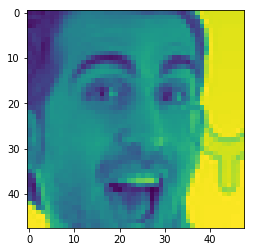

In [18]:
plt.imshow(test_faces[239].reshape(48,48))

#### Final Accuracy

In [15]:
final_loss, final_acc = saved_model.evaluate(test_faces, test_emotions, verbose = 1)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

3230/3230 [==============================] - 16s 5ms/step
Final loss: 1.3474, final accuracy: 0.4783
